In [1]:
import os, time
import torch, torchvision
import cv2, PIL
import matplotlib.pyplot as plt
import torch.nn as nn

import random
import numpy as np

import SimpleITK as sitk
import nibabel as nib
from vedo import Volume, show

In [2]:
# 96 slices center crop

# 뇌 영상만 따로 따낸 이미지 (T1_corrected OR brain.mgz) -> 둘이 같은 영상

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED']=str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=True

In [5]:
hyperparameters = {"SEED": 24,
                   "TEST_PORTION": 0.2,
                   "EPOCHS": 30,
                   "BATCH_SIZE": 1,
                   "LR": 1e-4,
                   "model_save_path": "C:/Users/PC00/Desktop/ASD_Project/save_path/MR_Transformer(Cropped).pt"}

In [6]:
seed_everything(hyperparameters["SEED"])

In [7]:
from Dataset import train_ctrl_path, train_ASD_path, test_ctrl_path, test_ASD_path

print(len(train_ctrl_path))
print(len(train_ASD_path))
print(len(test_ctrl_path))
print(len(test_ASD_path))

c:\Users\PC00\anaconda3\envs\torch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


45
152
11
38


In [18]:
import skimage.transform as sk_transform
from Preprocessing import get_boundaries

def normalize(voxel):
    minimum = np.min(voxel)
    maximum = np.max(voxel)
    return ( (voxel - minimum) / (maximum - minimum) * 255 ).astype(np.uint8)

def crop_3d(voxel):
    sagittal = voxel[128, ...]
    axial = voxel[:, 128, :]
    coronal = voxel[..., 128]

    sz, sy, w1, h1  = get_boundaries(normalize(sagittal))
    ax, az, w2, h2 = get_boundaries(normalize(axial))
    cx, cy, w3, h3 = get_boundaries(normalize(coronal))
    
    cropped_voxel = sk_transform.resize(voxel[max(ax, cx): max(ax+w2, cx+w3), max(sy, cy):max(sy+h1, cy+h3), max(sz, az):max(sz+w1, az+h2)], (128, 128, 128))
    return cropped_voxel

In [23]:
from Readpath import ASD_path, ctrl_path
ASD_sample = crop_3d(nib.load(ASD_path[10]).get_fdata())
ctrl_sample = crop_3d(nib.load(ctrl_path[0]).get_fdata())

print(ASD_sample.shape)
print(ctrl_sample.shape)

(128, 128, 128)
(128, 128, 128)


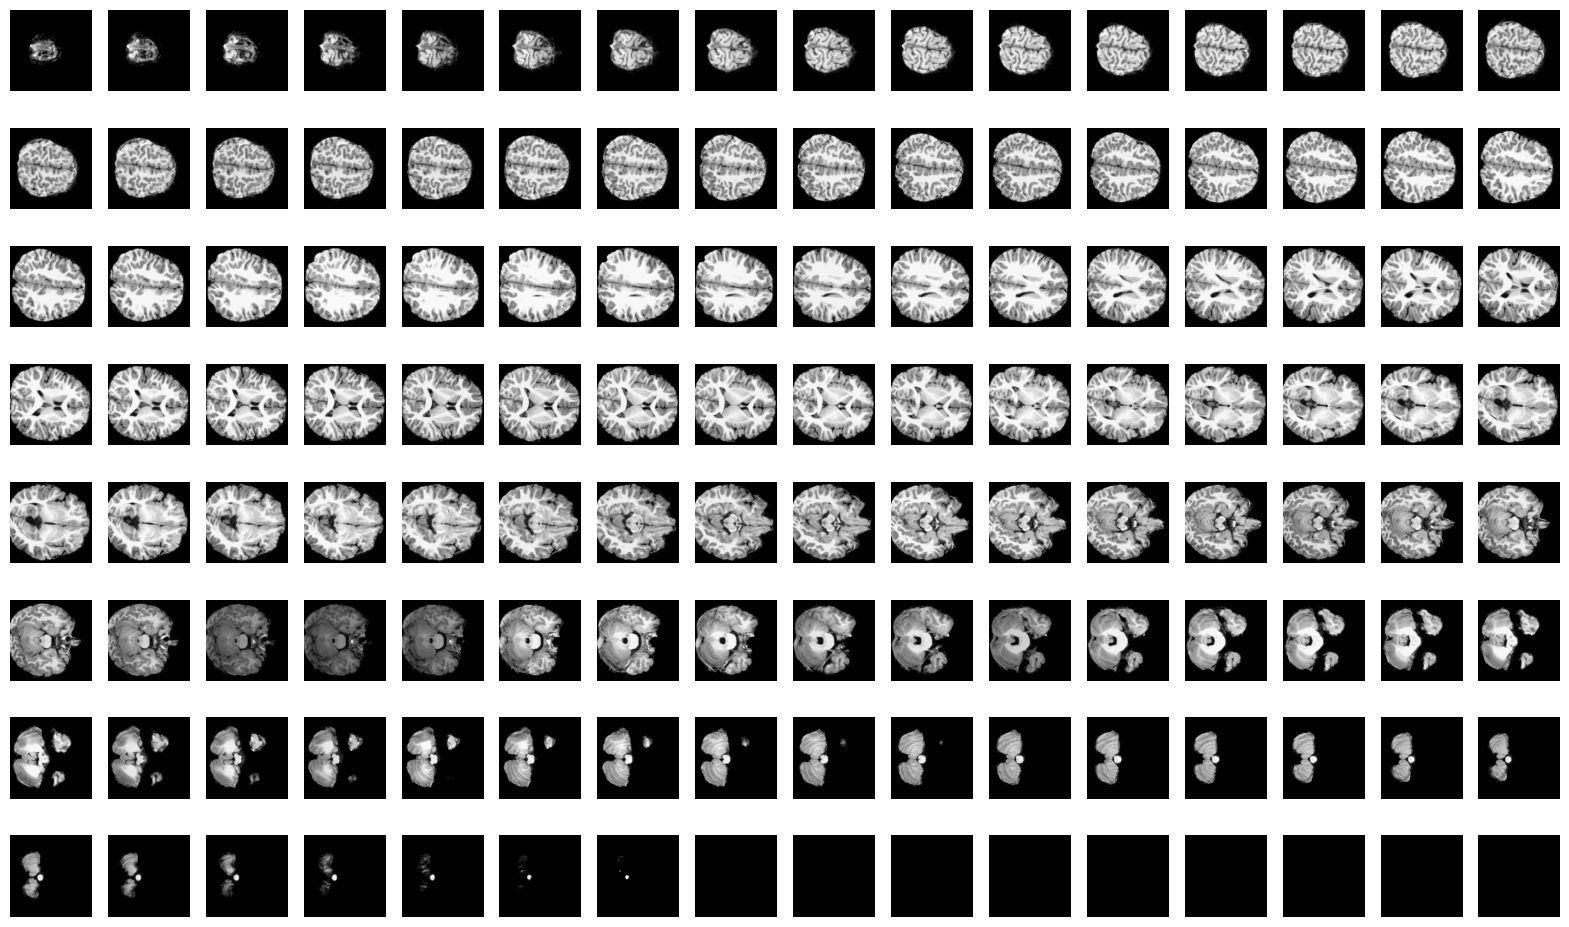

In [39]:
plt.figure(figsize=(20, 12))
for i in range(ASD_sample.shape[0]):
    plt.subplot(8, 16, i+1), plt.imshow(ASD_sample[:, i, :], cmap="Greys_r")
    plt.axis('off')

In [49]:
def safe_divide(numerator, denominator):
    denominator = np.where(denominator==0, 1, denominator)
    return ( numerator / denominator )

def LbyR(voxel):
    _, x, _ = voxel.shape
    left = voxel[:x//2, ...]
    right = np.flip(voxel[x//2:, ...], axis=0)
    return safe_divide(left, right)

ASD_ratio = LbyR(ASD_sample)
ASD_ratio.shape

(64, 128, 128)

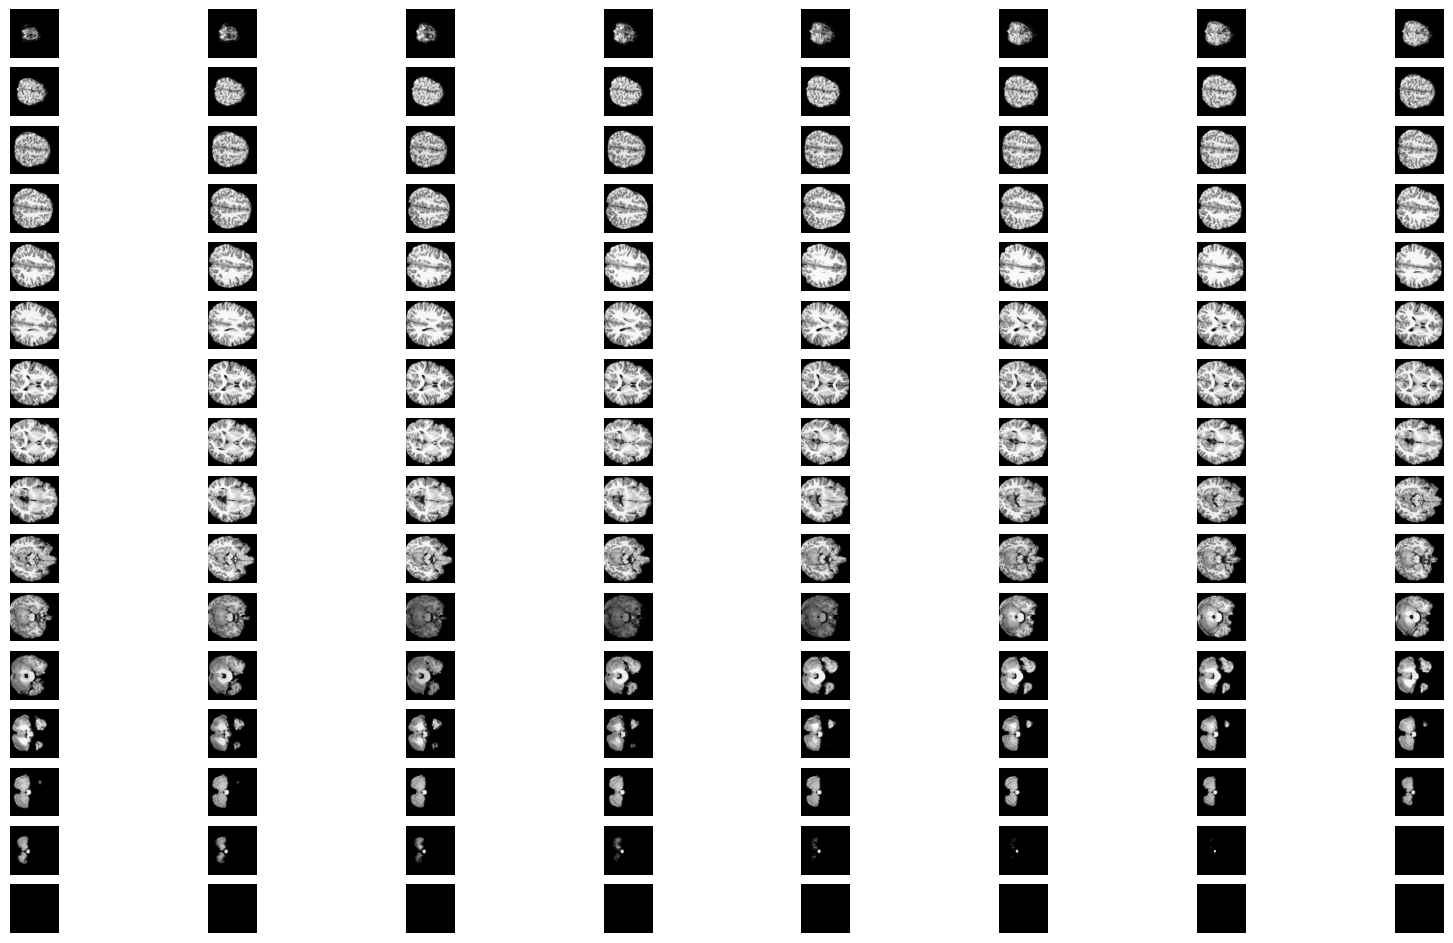

In [53]:
plt.figure(figsize=(20, 12))
for i in range(ASD_sample.shape[1]):
    plt.subplot(16, 8, i+1), plt.imshow(ASD_sample[:, i, :], cmap="Greys_r")
    plt.axis('off')

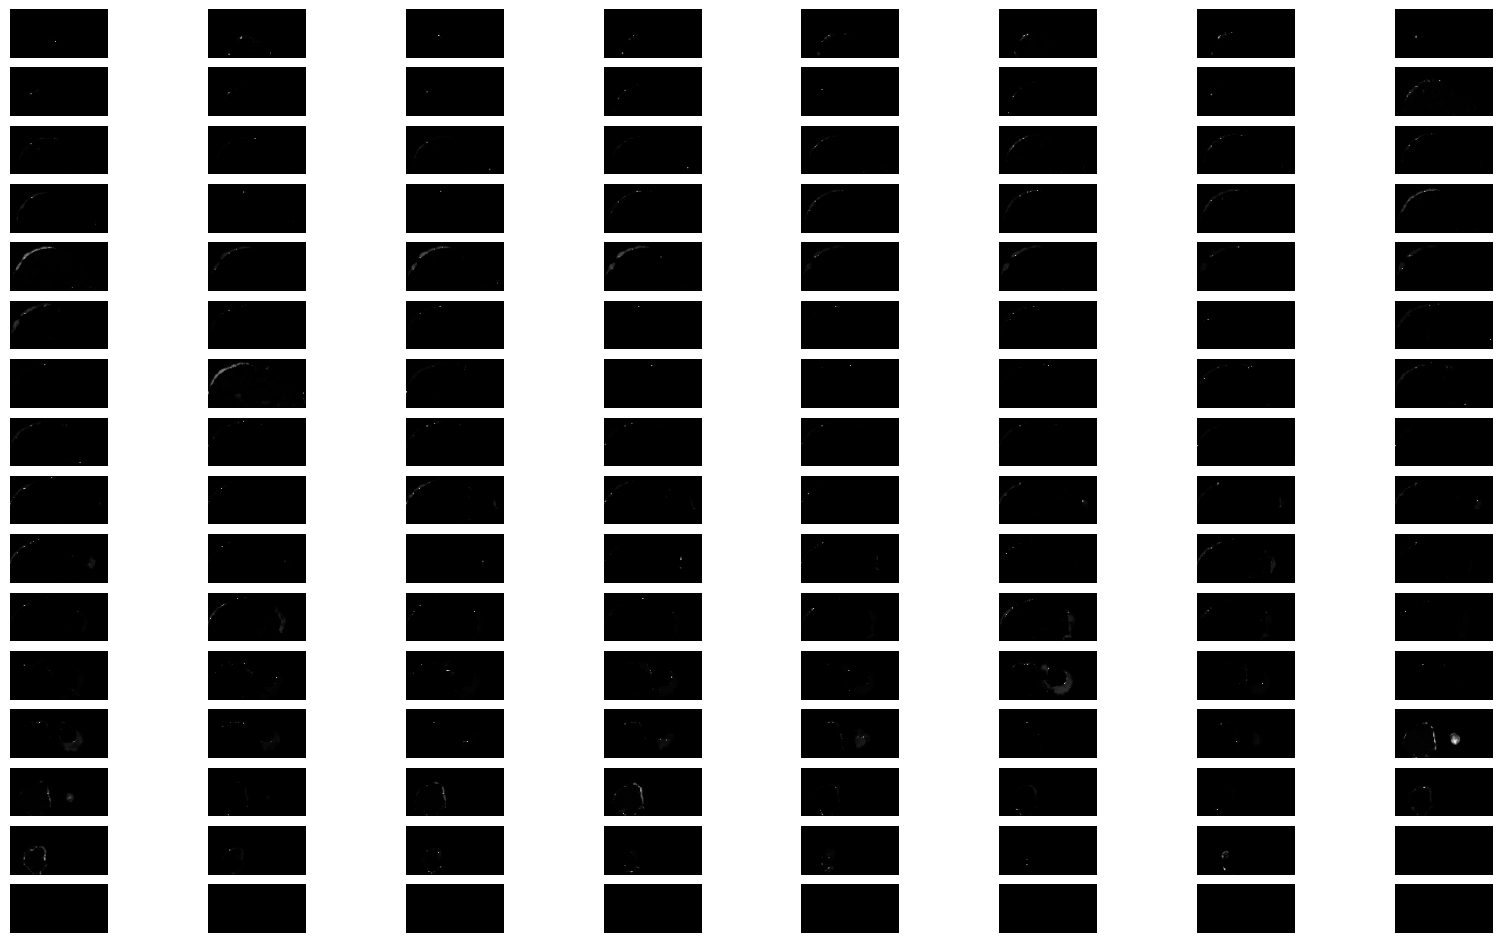

In [52]:
plt.figure(figsize=(20, 12))
for i in range(ASD_ratio.shape[1]):
    plt.subplot(16, 8, i+1), plt.imshow(ASD_ratio[:, i, :], cmap="Greys_r")
    plt.axis('off')

In [21]:
from Readpath import ctrl_path
from Preprocessing import crop_brain
import nibabel as nib
import numpy as np
import torchvision
import PIL
sample = nib.load(ctrl_path[0]).get_fdata()[:, 128, :]
minimum = np.min(sample)
maximum = np.max(sample)
normalized = crop_brain(( (sample - minimum) / (maximum - minimum) * 255 ).astype(np.uint8))
elast_deform = torchvision.transforms.Compose([
    torchvision.transforms.ElasticTransform(
    alpha=50.0,             # Higher alpha means more intense deformation
    sigma=5.0,              # Smoothing factor
    interpolation=torchvision.transforms.InterpolationMode.BILINEAR,
    fill=0),
    torchvision.transforms.Resize((224, 224))
])
elastic = elast_deform(PIL.Image.fromarray(normalized))

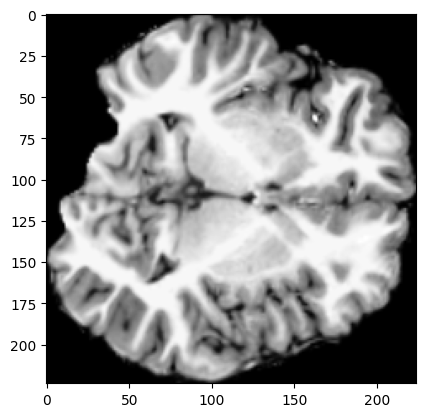

In [22]:
import matplotlib.pyplot as plt
plt.imshow(elastic, cmap="Greys_r")

In [7]:
from huggingface_hub import cached_assets_path

assets_path = cached_assets_path(library_name="datasets", namespace="SQuAD", subfolder="download")

c:\Users\PC00\anaconda3\envs\torch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import timm

class Model(nn.Module):
    def __init__(self, classes=2):
        super().__init__()
        self.model = timm.create_model('deit_tiny_distilled_patch16_224', pretrained=True)
        self.final_fc = nn.Linear(in_features=1000, out_features=classes)
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x):
        x = self.model(x)
        x = self.final_fc(x)
        x = self.softmax(x)
        
        return x

In [4]:
model = Model()
model

Model(
  (model): VisionTransformerDistilled(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=192, out_features=576, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=192, out_features=192, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=192, out_features=768, bias=True)
          (act): GELU(approximate='none')

In [9]:
InitialBlock = nn.Sequential(
    nn.Conv3d(in_channels=1, out_channels=2, kernel_size=1, stride=1),
    nn.BatchNorm3d(num_features=2),
    nn.ReLU(),
    nn.MaxPool3d(2, 2)
)

ResBlock1 = nn.Sequential(
    nn.Conv3d(2, 2, 1, 1),
    nn.BatchNorm3d(2),
    nn.ReLU(),
    nn.Conv3d(2, 4, 7, 2, 3),
    nn.BatchNorm3d(4),
    nn.ReLU(),
    nn.Conv3d(4, 4, 1, 1),
    nn.BatchNorm3d(4),
    nn.ReLU(),
    nn.Dropout(p=0.5)
)

ResBlock2 = nn.Sequential(
    nn.Conv3d(4, 4, 1, 1),
    nn.BatchNorm3d(4),
    nn.ReLU(),
    nn.Conv3d(4, 8, 7, 2, 3),
    nn.BatchNorm3d(8),
    nn.ReLU(),
    nn.Conv3d(8, 8, 1, 1),
    nn.BatchNorm3d(8),
    nn.ReLU(),
    nn.Dropout(p=0.5)
)

ResBlock3 = nn.Sequential(
    nn.Conv3d(8, 8, 1, 1),
    nn.BatchNorm3d(8),
    nn.ReLU(),
    nn.Conv3d(8, 16, 7, 2, 3),
    nn.BatchNorm3d(16),
    nn.ReLU(),
    nn.Conv3d(16, 16, 1, 1),
    nn.BatchNorm3d(16),
    nn.ReLU(),
    nn.Dropout(p=0.5)
)

SkipConnection1 = nn.Sequential(
    nn.Identity(),
    nn.Conv3d(in_channels=2, out_channels=4, kernel_size=1, stride=1),
    nn.MaxPool3d(2, 2),
    nn.ReLU(),
    nn.Dropout(p=0.5)
)

SkipConnection2 = nn.Sequential(
    nn.Identity(),
    nn.Conv3d(in_channels=4, out_channels=8, kernel_size=1, stride=1),
    nn.MaxPool3d(2, 2),
    nn.ReLU(),
    nn.Dropout(p=0.5)
)

SkipConnection3 = nn.Sequential(
    nn.Identity(),
    nn.Conv3d(in_channels=8, out_channels=16, kernel_size=1, stride=1),
    nn.MaxPool3d(2, 2),
    nn.ReLU(),
    nn.Dropout(p=0.5)
    )

maxpool = nn.MaxPool3d(2,2)

In [10]:
x = torch.rand(1, 1, 96, 224, 224)

x = InitialBlock(x)
print(f"Initial: {x.shape}")
print()

x1 = ResBlock1(x)
print(f"Res1: {x1.shape}")
x2 = SkipConnection1(x)
print(f"Skip1: {x2.shape}")
x = x1 + x2
print(f"Bottle1: {x.shape}")
print()

x1 = ResBlock2(x)
print(f"Res2: {x1.shape}")
x2 = SkipConnection2(x)
print(f"Skip2: {x2.shape}")
x = x1 + x2
print(f"Bottle2: {x.shape}")
print()

x1 = ResBlock3(x)
print(f"Res3: {x1.shape}")
x2 = SkipConnection3(x)
print(f"Skip3: {x2.shape}")
x = x1 + x2
print(f"Bottle3: {x.shape}")
print()

x = maxpool(x)
print(f"Max Pooling: {x.shape}")

Initial: torch.Size([1, 2, 48, 112, 112])

Res1: torch.Size([1, 4, 24, 56, 56])
Skip1: torch.Size([1, 4, 24, 56, 56])
Bottle1: torch.Size([1, 4, 24, 56, 56])

Res2: torch.Size([1, 8, 12, 28, 28])
Skip2: torch.Size([1, 8, 12, 28, 28])
Bottle2: torch.Size([1, 8, 12, 28, 28])

Res3: torch.Size([1, 16, 6, 14, 14])
Skip3: torch.Size([1, 16, 6, 14, 14])
Bottle3: torch.Size([1, 16, 6, 14, 14])

Max Pooling: torch.Size([1, 16, 3, 7, 7])


In [7]:
root = "F:\\ASD\\DATA\\ASD\\398\\freesurfer\\stats\\brainvol.stats"

In [8]:
import os
with open(root, 'r') as file:
    for line in file:
        print(line)

================ RESULTS ================

Sat Jul 13 15:03:29 2024    main_funcs.prof



         26 function calls in 2.502 seconds



   Random listing order was used



   ncalls  tottime  percall  cumtime  percall filename:lineno(function)

        5    0.000    0.000    2.502    0.500 C:\Users\PC00\AppData\Local\Temp\ipykernel_19720\2744924311.py:6(add_slow)

        5    0.000    0.000    0.000    0.000 C:\Users\PC00\AppData\Local\Temp\ipykernel_19720\2744924311.py:10(add_fast)

        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}

        5    2.502    0.500    2.502    0.500 {built-in method time.sleep}

       10    0.000    0.000    0.000    0.000 {method 'append' of 'list' objects}







================ RESULTS ================



Sat Jul 13 15:03:29 2024    main_funcs.prof







         26 function calls in 2.502 seconds







   Random listing order was used







   ncalls  tottime  percall  cumtime  percall filename:lineno

In [61]:
temp = torch.randn((1, 64, 128, 128))

layer1 = nn.Conv3d(in_channels=1, out_channels=2, kernel_size=3, stride=1)
layer2 = nn.Conv3d(in_channels=2, out_channels=2**2, kernel_size=3, stride=1)
layer3 = nn.Conv3d(in_channels=2**2, out_channels=2**3, kernel_size=3, stride=1)
pool = nn.MaxPool3d(2,2)

out = pool(layer1(temp))
out = pool(layer2(out))
out = pool(layer3(out))

out.shape

torch.Size([8, 6, 14, 14])